In [52]:
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import math
import random
import numpy as np
from copy import deepcopy
from collections import defaultdict

In [2]:
post_data, threads, user_data = pickle.load(open('/home/nirmal/topic_tagging/query_TT/Notebooks/reddit-cyber.pkl', 'rb'))

In [3]:
tr_pids, tr_doc_info, te_pids, exp_users = pickle.load(open('/home/nirmal/topic_tagging/query_TT/Notebooks/reddit_dataset_cyber.pkl','rb'))

In [18]:
exp_users

['Internexus',
 'tweedge',
 'nunley',
 'stacksmasher',
 'danfirst',
 'bughousenut',
 'corn_29',
 'Norcal712',
 'xAlphamang',
 'Rsubs33',
 'Temptunes48',
 'GingasaurusWrex',
 'Trini_Vix7',
 'reckless_boar',
 'hunglowbungalow',
 'Cautious_General_177',
 'pcapdata',
 'Slateclean',
 'LaughterHouseV',
 '1128327',
 'TrustmeImaConsultant',
 'Benoit_In_Heaven',
 'BottledH2O',
 'lawtechie',
 'heisenbergerwcheese',
 'ThePorko',
 'right_closed_traffic',
 'citrus_sugar',
 'BankEmoji',
 'max1001',
 'dflame45',
 'iSheepTouch',
 'Security_Chief_Odo',
 'foxhelp',
 '1Second2Name5things',
 'rksd',
 'Obi_Maximus_Windu',
 'Ignorad',
 'red_shrike',
 'Mrhiddenlotus',
 'genericindianguy',
 '800oz_gorilla',
 'HeyGuyGuyGuy',
 'payne747',
 'ShameNap',
 'seanprefect',
 'guru-1337',
 'Ghawblin',
 'prestelpirate',
 'LumpyStyx',
 'CosmicMiru',
 'uid_0',
 'ayhme',
 'Kern3LP4niK',
 'HeWhoChokesOnWater',
 'AutoModerator',
 'mellonauto',
 'OMGWTHEFBBQ',
 'chazzybeats',
 'atamicbomb',
 'Armigine',
 'Blacksun388',
 'Zero

In [4]:
threads = threads['cybersecurity']

In [5]:
len(post_data), len(threads), len(user_data)

(66992, 953, 21589)

In [45]:
node_attr = defaultdict(dict)
edges = []
user_edges = defaultdict(int)
for rid in threads:
    
    cur_tree = threads[rid][0]
    tr_te = 'Train' if rid in tr_pids else 'Test' if rid in te_pids else 'None'
    for edge in cur_tree.edges():
        edges.append(list(edge)+[{'type':'p-p'}])
        u1 = post_data[edge[0]]['user_name']
        u2 = post_data[edge[1]]['user_name']
        edges.append([u1, edge[0], {'type':'u-p'}])
        edges.append([u2, edge[1], {'type':'u-p'}])
        
        node_attr[u1]={'type':'User', 'chosen':'Yes' if u1 in exp_users else 'No'}
        node_attr[u2]={'type':'User', 'chosen':'Yes' if u2 in exp_users else 'No'}
        if u1!=u2:
            user_edges[tuple(sorted([u1,u2]))]+=1
        node_attr[edge[0]]={**post_data[edge[0]],**{'split':tr_te}}
        node_attr[edge[1]]={**post_data[edge[1]],**{'split':tr_te}}

In [62]:
user_edge_wgts = sorted(user_edges.values())

In [46]:
user_G = nx.Graph([[i[0],i[1],{'weight':j}] for i,j in user_edges.items()])
nx.set_node_attributes(G, {i:j for i,j in node_attr.items() if j['type']=='User'})

In [63]:
for i in [5,10,25,50,75,90,95,99]:
    print(f"{i} - {np.percentile(user_edge_wgts,i)}")

5 - 1.0
10 - 1.0
25 - 1.0
50 - 1.0
75 - 1.0
90 - 2.0
95 - 3.0
99 - 5.0


(array([402.,  50.,  43.,  17.,  14.,   4.,   4.,   4.,   1.,   2.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.]),
 array([ 5.        ,  6.02631579,  7.05263158,  8.07894737,  9.10526316,
        10.13157895, 11.15789474, 12.18421053, 13.21052632, 14.23684211,
        15.26315789, 16.28947368, 17.31578947, 18.34210526, 19.36842105,
        20.39473684, 21.42105263, 22.44736842, 23.47368421, 24.5       ,
        25.52631579, 26.55263158, 27.57894737, 28.60526316, 29.63157895,
        30.65789474, 31.68421053, 32.71052632, 33.73684211, 34.76315789,
        35.78947368, 36.81578947, 37.84210526, 38.86842105, 39.89473684,
        40.92105263, 41.94736842, 42.97368421, 44.        ]),
 <BarContainer object of 38 artists>)

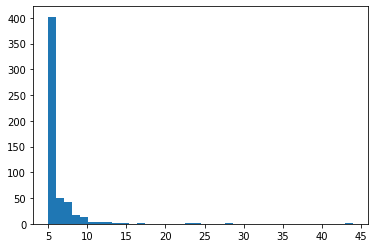

In [64]:
plt.hist([i for i in user_edges.values() if i>=5], bins=38)

In [42]:
len(user_G), len(user_G.edges())

(19774, 41502)

In [7]:
G = nx.DiGraph(edges)
nx.set_node_attributes(G, node_attr)

In [21]:
user_edges = []
for u1 in tqdm(list(node_attr.keys())):
    for u2 in list(node_attr.keys()):
        if u1==u2: continue
        nx.all_simple_paths(G, u1, u2, cutoff=3)

  1%|▉                                                                           | 876/75333 [01:19<1:53:02, 10.98it/s]


KeyboardInterrupt: 

In [8]:
len(G), len(G.edges())

(75333, 110165)

In [47]:
from neo4j import GraphDatabase
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response
    
conn = Neo4jConnection(uri="neo4j://localhost:7687", 
                       user="neo4j",              
                       pwd="2000")

In [14]:
batch_data = {'batch':[]}
for node in tqdm(G.nodes()):
    check_q = 'match (n) where n.id=$id return n'

    cat_dict = G.nodes[node]
    cat_dict['id'] = node
#     if 'pages' in cat_dict: del cat_dict['pages']
    batch_data['batch'].append(cat_dict)
    
    if len(batch_data['batch'])==50000:
        conn.query("UNWIND $batch as row CREATE (n:reddit) SET n+= row",batch_data)
        batch_data = {'batch':[]}
conn.query("UNWIND $batch as row CREATE (n:reddit) SET n+= row",batch_data)

100%|█████████████████████████████████████████████████████████████████████████| 75333/75333 [00:03<00:00, 21115.97it/s]


[]

In [15]:
batch_rel = {'batch':[]}
for idx,(u,v,d) in enumerate(tqdm(G.edges(data=True))):
    rel_dict = {'from':u, 'to':v, }
    batch_rel['batch'].append(rel_dict)
    if len(batch_rel['batch'])<10000:        
        continue
    q = "\
UNWIND $batch as row \
MATCH (a:reddit {id: row.from}) \
MATCH (b:reddit {id:row.to}) \
MERGE (a)-[rel: PARENT_OF]->(b) \
SET rel+= row\
    "
#     break
    conn.query(q,batch_rel)
    batch_rel = {'batch':[]}

100%|███████████████████████████████████████████████████████████████████████| 110165/110165 [00:05<00:00, 18839.16it/s]


In [49]:
batch_data = {'batch':[]}
for node in tqdm(user_G.nodes()):
    check_q = 'match (n) where n.id=$id return n'

    cat_dict = G.nodes[node]
    cat_dict['id'] = node
#     if 'pages' in cat_dict: del cat_dict['pages']
    batch_data['batch'].append(cat_dict)
    
    if len(batch_data['batch'])==50000:
        conn.query("UNWIND $batch as row CREATE (n:reddit_users) SET n+= row",batch_data)
        batch_data = {'batch':[]}
conn.query("UNWIND $batch as row CREATE (n:reddit_users) SET n+= row",batch_data)

100%|████████████████████████████████████████████████████████████████████████| 19774/19774 [00:00<00:00, 695970.99it/s]


[]

In [43]:
conn.query("CREATE INDEX FOR (u:reddit_users) on u.id")

100%|████████████████████████████████████████████████████████████████████████| 19774/19774 [00:00<00:00, 673680.61it/s]


Query failed: {code: Neo.ClientError.Schema.EquivalentSchemaRuleAlreadyExists} {message: An equivalent index already exists, 'Index( id=18, name='index_afb6d691', type='RANGE', schema=(:reddit_users {id}), indexProvider='range-1.0' )'.}


In [50]:
batch_rel = {'batch':[]}
for idx,(u,v,d) in enumerate(tqdm(user_G.edges(data=True))):
    rel_dict = {'from':u, 'to':v, 'weight':d['weight']}
    batch_rel['batch'].append(rel_dict)
    if len(batch_rel['batch'])<10000:        
        continue
    q = "\
UNWIND $batch as row \
MATCH (a:reddit_users {id: row.from}) \
MATCH (b:reddit_users {id:row.to}) \
MERGE (a)-[rel: PARENT_OF]-(b) \
SET rel+= row\
"
#     break
    conn.query(q,batch_rel)
    batch_rel = {'batch':[]}

100%|█████████████████████████████████████████████████████████████████████████| 41262/41262 [00:02<00:00, 16644.93it/s]


In [48]:
conn.query('MATCH (n:reddit_users) DETACH DELETE n;')

[]

In [14]:
list(G.edges(data=True))[0]

('hrvyx7', 'fy6pp9x', {})

In [34]:
G_und = G.to_undirected()

In [35]:
def get_nei_nodes(nid, dep=3):
    queue = []
    visited = set()
    queue.append([nid,0])
    visited.add(nid)
    
    nids = []
    while queue:
        src = queue.pop(0)
        nids.append(src[0])
        if src[1]<dep:
            for sibid in nx.all_neighbors(G_und, src[0]):
                if sibid not in visited:
                    queue.append([sibid, src[1]+1])
                    visited.add(sibid)
    return nids

In [42]:
for i in random.sample(G.nodes(),5):
    sub_nodes=get_nei_nodes(i,3)
    sub_G = G.subgraph(sub_nodes)
    print(len(sub_G), len(sub_G.edges()))

419 512
11 11
6 5
115 120
245 248


In [37]:
len(sub_nodes)

559